In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math

# --------------------
# 기본 변수 설정
# --------------------
INPUT  = 20           # CSI 데이터의 가로
INPUT2 = 1080         # CSI 데이터의 세로 
EXPERIMENT = 5        # 각 위치에서 사용되는 패킷(이미지) 수 (한 위치에서 5장의 CSI 이미지)
NODE1  = 100          # 첫 번째 Fully Connected (FC) 레이어의 노드 수
NODE2  = 100          # 두 번째 Fully Connected (FC) 레이어의 노드 수
OUTPUT = 2            # 최종 출력 차원 (예: x, y 좌표 예측)

TRAIN = 114           # 학습 데이터의 위치 수
TEST  = 27            # 테스트 데이터의 위치 수
training_epochs = 250 # 전체 학습 에폭 수(한 번에 학습하는 횟수)
learning_rate = 1e-5  # 옵티마이저 학습률(학습률)

# Train 데이터 X 좌표
y1 = [0, 127.5, 255.0, 382.5, 510.0, 637.5, 765.0, 892.5, 1020.0, 1147.5, 1275.0, 1402.5, 1530.0, 1657.5, 1785.0, 1912.5, 2040.0, 2167.5, 2295.0, 
      0, 255.0, 510.0, 765.0, 1020.0, 1275.0, 1530.0, 1785.0, 2040.0, 2295.0, 
      0, 127.5, 255.0, 382.5, 510.0, 637.5, 765.0, 892.5, 1020.0, 1147.5, 1275.0, 1402.5, 1530.0, 1657.5, 1785.0, 1912.5, 2040.0, 2167.5, 2295.0,
      892.5, 1147.5, 1275.0, 1530.0,
      892.5, 1020.0, 1147.5, 1275.0, 1402.5, 1530.0,
      765.0, 892.5, 1147.5, 1275.0, 1530.0, 1657.5,
      637.5, 892.5, 1657.5, 
      510, 637.5, 1657.5, 1785.0,
      382.5, 637.5, 1657.5, 1912.5, 2040.0,
      382.5, 510, 637.5, 1657.5, 1785, 1912.5, 2040.0,
      382.5, 637.5, 1657.5, 1912.5,
      382.5, 510, 637.5, 1785, 1912.5, 2040.0,
      382.5, 637.5, 892.5, 1147.5, 1402.5, 1657.5, 1912.5,
      382.5, 510.0, 637.5, 765.0, 892.5, 1020.0, 1147.5, 1275.0, 1402.5, 1530.0, 1657.5, 1785.0, 1912.5, 2040.0]

# Train 데이터 Y 좌표
y2 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
      180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 
      360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360,
      540, 540, 540, 540,
      720, 720, 720, 720, 720, 720,
      900, 900, 900, 900, 900, 900,
      1080, 1080, 1080,
      1260, 1260, 1260, 1260,
      1440, 1440, 1440, 1440, 1440,
      1620, 1620, 1620, 1620, 1620, 1620, 1620,
      1800, 1800, 1800, 1800,
      1980, 1980, 1980, 1980, 1980, 1980,
      2160, 2160, 2160, 2160, 2160, 2160, 2160,
      2340, 2340, 2340, 2340, 2340, 2340, 2340, 2340, 2340, 2340, 2340, 2340, 2340, 2340,]

# Test 데이터 X 좌표
y3 = [127.5, 382.5, 637.5, 892.5, 1147.5, 1402.5, 1657.5, 1912.5, 2167.5,
      1020, 1402.5,
      1020, 1402.5,
      765, 1785,
      510, 1785,
      510, 1785, 2040,
      510, 765, 1020, 1275, 1530, 1785, 2040 ]

# Test 데이터 Y 좌표
y4 = [180, 180, 180, 180, 180, 180, 180, 180, 180,
      540, 540, 
      900, 900,
      1080, 1080,
      1440, 1440,
      1800, 1800, 1800,
      2160, 2160, 2160, 2160, 2160, 2160, 2160]

# 데이터 정규화 과정
# 최대값 (정규화 기준)
max_x = 2295.0
max_y = 2340.0

# Train 데이터 정규화
y1 = [x / max_x for x in y1]  # X 좌표 정규화
y2 = [y / max_y for y in y2]  # Y 좌표 정규화

# Test 데이터 정규화
y3 = [x / max_x for x in y3]  # X 좌표 정규화
y4 = [y / max_y for y in y4]  # Y 좌표 정규화

# --------------------
# 데이터 로드 함수
# --------------------
def get_input(filename, sample, experiment, numdata):
    data = np.zeros((sample, experiment, INPUT2, numdata), dtype=np.float32)
    with open(filename, 'r') as f:
        diag_temp = f.read().split()
    idx = 0
    for i in range(sample):
        for p in range(experiment):
            for l in range(numdata):
                for m in range(INPUT2):
                    data[i, p, m, l] = float(diag_temp[idx])
                    idx += 1
    return data

# --------------------
# CNN 함수
# --------------------
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, (3,2), padding=(1,0)),
            nn.ReLU(),
            nn.MaxPool2d((8,2), stride=(4,2))
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 16, (3,2), padding=(1,0)),
            nn.ReLU(),
            nn.MaxPool2d((4,2), stride=(2,2))
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 8, (3,2), padding=(1,0)),
            nn.ReLU(),
            nn.MaxPool2d((1,2), stride=(1,2))
        )

        # Flatten 후 1064차원
        self.fc1 = nn.Linear(1064, NODE1)
        self.fc2 = nn.Linear(NODE1, NODE2)
        self.fc3 = nn.Linear(NODE2, OUTPUT)
            

    # CNN으로 이미지의 특징 추출 → Flatten → Fully Connected Layer로 분류 수행
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = torch.flatten(x, 1)
         # Fully Connected 단계: 두 FC 레이어 후 최종 2차원 출력 (정규화된 좌표)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# ----------------------------
# 데이터 로드
# ----------------------------
train_data = get_input("result_250227_train.txt", TRAIN, EXPERIMENT, INPUT)
test_data  = get_input("result_250227_test.txt",  TEST,  EXPERIMENT, INPUT)

# ----------------------------
# 6) 모델, 손실함수, 옵티마이저 설정
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model = CNNModel().to(device)                                    # 모델을 GPU 또는 CPU로 이동
mse_criterion = nn.MSELoss()                                     # 평균제곱오차(MSE) 손실 함수 사용
optimizer     = optim.Adam(model.parameters(), lr=learning_rate) # Adam 옵티마이저 사용

# --------------------
# 학습 및 테스트 Loop
# --------------------
for epoch in range(training_epochs): # 전체 학습을 training_epochs(250) 횟수만큼 반복
    # --- Training ---
    model.train()
    total_train_rmse = 0.0
    for j in range(EXPERIMENT): # 학습 데이터 반복 (EXPERIMENT × TRAIN)
        for i in range(TRAIN):
            x_ = train_data[i, j] # # i번째 위치, j번째 이미지
            x_tensor = torch.tensor(x_, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
            # CNN 입력 형식인 4차원 텐서 (batch, channel, height, width)로 맞춰주는 작업
            label_tensor = torch.tensor([[y1[i], y2[i]]], dtype=torch.float32).to(device)
            # 정답 라벨 텐서 만들기 → (1, 2) 크기의 라벨 텐서(x, y 정답 좌표)가 생성
            
            # 순전파 → 손실 계산 → 역전파
            optimizer.zero_grad() # 이전 step의 gradient 초기화
            pred = model(x_tensor) # 모델 예측값
            mse_loss = mse_criterion(pred, label_tensor) # 평균제곱오차
            rmse_loss = torch.sqrt(mse_loss) # 실제 거리 오차(루트 적용)
            rmse_loss.backward() # 오차 역전파
            optimizer.step() # 파라미터 업데트

            total_train_rmse += rmse_loss.item() # 이번 학습 샘플의 RMSE 값을 누적 저장

    avg_train_rmse = total_train_rmse / (TRAIN * EXPERIMENT) # 평균 RMSE 계산

    # --- Testing ---
    model.eval()
    sum_rmse = 0.0
    sum_dist_m = 0.0
    with torch.no_grad():
        for l in range(TEST):
            for j2 in range(EXPERIMENT):
                # 입력/라벨 텐서 생성
                x_ = test_data[l, j2]
                x_tensor = torch.tensor(x_, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
                # 정규화된 라벨
                label_tensor = torch.tensor([[y3[l], y4[l]]], dtype=torch.float32).to(device)

                # 1) RMSE (정규화)
                pred = model(x_tensor)
                mse = mse_criterion(pred, label_tensor)
                rmse = torch.sqrt(mse)
                sum_rmse += rmse.item()

                # 2) distance_accuracy(m) → 실제 좌표로 환산
                # pred_x_norm, pred_y_norm
                px_norm = pred[0,0].item() # 예측 x좌표 (정규화)
                py_norm = pred[0,1].item()  # 예측 y좌표
                rx_norm = label_tensor[0,0].item() # 실제 x
                ry_norm = label_tensor[0,1].item() # 실제 y

                # 3) 정규화 해제 (cm 단위)
                px_cm = px_norm * max_x
                py_cm = py_norm * max_y
                rx_cm = rx_norm * max_x
                ry_cm = ry_norm * max_y
                
                # 4) 거리 계산 (유클리디안 거리)
                dx_cm = px_cm - rx_cm
                dy_cm = py_cm - ry_cm
                dist_cm = math.sqrt(dx_cm*dx_cm + dy_cm*dy_cm)
                dist_m  = dist_cm / 100.0
                sum_dist_m += dist_m
                
    # 평균값 출력
    avg_test_rmse   = sum_rmse / (TEST * EXPERIMENT)
    avg_dist_m      = sum_dist_m / (TEST * EXPERIMENT)
    print(f"[Epoch {epoch+1}/{training_epochs}] "
          f"Train Loss={avg_train_rmse:.4f}, Test Loss={avg_test_rmse:.4f}, "
          f"distance_accuracy={avg_dist_m:.3f}m")

# --------------------
# 최종 예측 결과 저장
# --------------------
model.eval() # 모델을 평가 모드로 전환
sum_dist_m2 = 0.0 # 거리 오차 누적합 (단위: m)
result1 = np.zeros((TEST, EXPERIMENT), dtype=np.float32) # 예측한 x좌표(정규화) 저장용 배열
result2 = np.zeros((TEST, EXPERIMENT), dtype=np.float32) # 예측한 y좌표(정규화) 저장용 배열

with torch.no_grad(): # 예측 반복 & 거리 계산
    for l in range(TEST):
        for j in range(EXPERIMENT):
            x_ = test_data[l, j] # 입력 & 라벨 구성
            x_tensor = torch.tensor(x_, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
            label_tensor = torch.tensor([[y3[l], y4[l]]], dtype=torch.float32).to(device)

            # 예측 좌표 및 정답 좌표 추출
            pred = model(x_tensor)
            px_norm = pred[0,0].item()
            py_norm = pred[0,1].item()
            rx_norm = label_tensor[0,0].item()
            ry_norm = label_tensor[0,1].item()

            # distance_accuracy(m) 계산
            px_cm = px_norm * max_x
            py_cm = py_norm * max_y
            rx_cm = rx_norm * max_x
            ry_cm = ry_norm * max_y

            # 정규화 해제 → 실제 단위 (cm)
            dist_m = math.sqrt((px_cm-rx_cm)**2 + (py_cm-ry_cm)**2) / 100.0
            sum_dist_m2 += dist_m

            # 예측 결과 저
            result1[l][j] = px_norm
            result2[l][j] = py_norm

final_acc_m = sum_dist_m2 / (TEST * EXPERIMENT)
print(f"Final distance_accuracy(m): {final_acc_m:.4f}")

filename = "result_cnn_prediction.txt"
with open(filename, "w") as f:
    for i in range(TEST):
        for j in range(EXPERIMENT):
            f.write(f"{result1[i][j]:.6f} {result2[i][j]:.6f}\n")

print("Done! Saved predictions to", filename)


[Epoch 1/250] Train Loss=0.3759, Test Loss=0.2901, distance_accuracy=9.538m
[Epoch 2/250] Train Loss=0.3048, Test Loss=0.2878, distance_accuracy=9.460m
[Epoch 3/250] Train Loss=0.3009, Test Loss=0.2864, distance_accuracy=9.416m
[Epoch 4/250] Train Loss=0.2979, Test Loss=0.2845, distance_accuracy=9.352m
[Epoch 5/250] Train Loss=0.2935, Test Loss=0.2801, distance_accuracy=9.209m
[Epoch 6/250] Train Loss=0.2839, Test Loss=0.2713, distance_accuracy=8.921m
[Epoch 7/250] Train Loss=0.2692, Test Loss=0.2604, distance_accuracy=8.562m
[Epoch 8/250] Train Loss=0.2488, Test Loss=0.2431, distance_accuracy=7.993m
[Epoch 9/250] Train Loss=0.2206, Test Loss=0.2209, distance_accuracy=7.262m
[Epoch 10/250] Train Loss=0.1970, Test Loss=0.2058, distance_accuracy=6.761m
[Epoch 11/250] Train Loss=0.1790, Test Loss=0.1954, distance_accuracy=6.418m
[Epoch 12/250] Train Loss=0.1644, Test Loss=0.1883, distance_accuracy=6.187m
[Epoch 13/250] Train Loss=0.1517, Test Loss=0.1849, distance_accuracy=6.075m
[Epoch 1

### 그래프

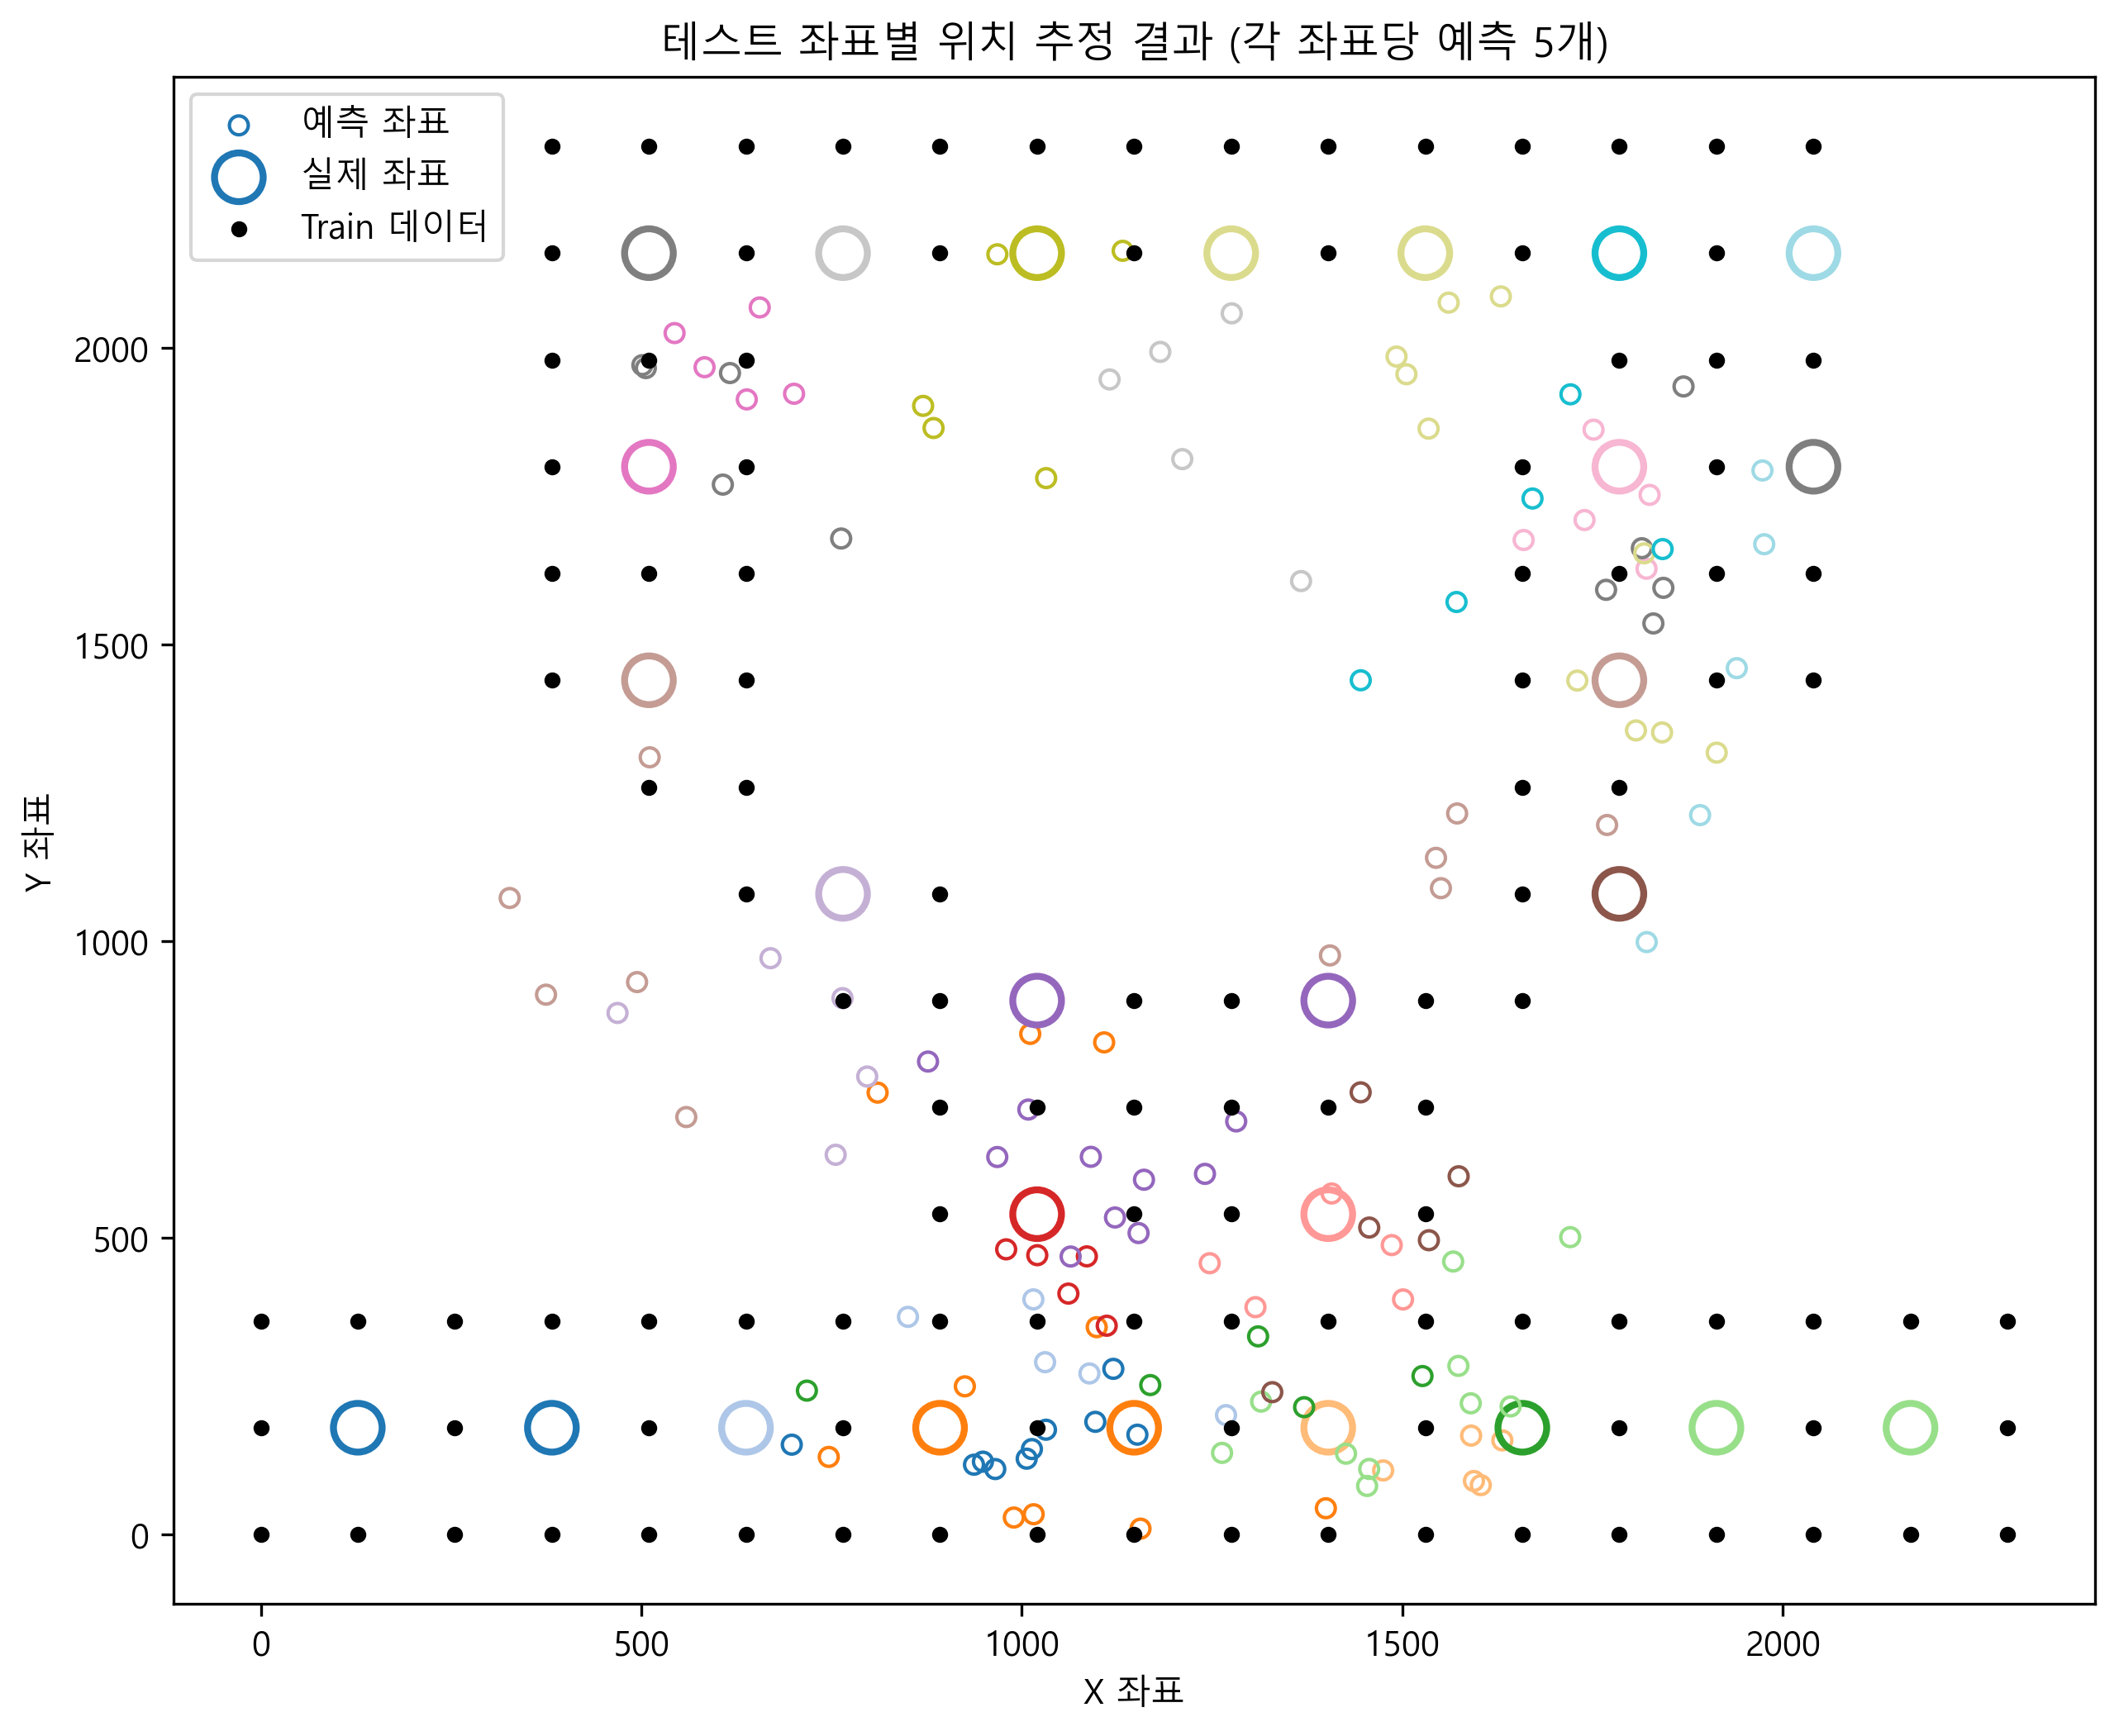

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# ------------------------------------------------------------------
# 1) 예측 결과 불러오기
#    (각 테스트 포인트당 5개의 예측값)
# ------------------------------------------------------------------
result = np.loadtxt('result_cnn_prediction.txt')  # shape: (numTest*EXPERIMENT, 2)
EXPERIMENT = 5    # 각 테스트 지점당 예측 횟수
numTest = 27      # 테스트 지점(좌표) 개수

# 좌표 스케일 복원
result[:, 0] *= 2295
result[:, 1] *= 2340

# ------------------------------------------------------------------
# 2) Train 데이터 좌표, Test 데이터 좌표
# ------------------------------------------------------------------
y1 = np.array([0, 127.5, 255.0, 382.5, 510.0, 637.5, 765.0, 892.5, 1020.0, 1147.5, 
               1275.0, 1402.5, 1530.0, 1657.5, 1785.0, 1912.5, 2040.0, 2167.5, 2295.0, 
               0, 255.0, 510.0, 765.0, 1020.0, 1275.0, 1530.0, 1785.0, 2040.0, 2295.0, 
               0, 127.5, 255.0, 382.5, 510.0, 637.5, 765.0, 892.5, 1020.0, 1147.5, 
               1275.0, 1402.5, 1530.0, 1657.5, 1785.0, 1912.5, 2040.0, 2167.5, 2295.0, 
               892.5, 1147.5, 1275.0, 1530.0, 
               892.5, 1020.0, 1147.5, 1275.0, 1402.5, 1530.0, 
               765.0, 892.5, 1147.5, 1275.0, 1530.0, 1657.5, 
               637.5, 892.5, 1657.5, 
               510, 637.5, 1657.5, 1785.0, 
               382.5, 637.5, 1657.5, 1912.5, 2040.0, 
               382.5, 510, 637.5, 1657.5, 1785, 1912.5, 2040.0, 
               382.5, 637.5, 1657.5, 1912.5, 
               382.5, 510, 637.5, 1785, 1912.5, 2040.0, 
               382.5, 637.5, 892.5, 1147.5, 1402.5, 1657.5, 1912.5, 
               382.5, 510.0, 637.5, 765.0, 892.5, 1020.0, 1147.5, 1275.0, 1402.5, 1530.0, 1657.5, 1785.0, 1912.5, 2040.0])
               
y2 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
               180, 180, 180, 180, 180, 180, 180, 180, 180, 180, 
               360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 360, 
               540, 540, 540, 540, 
               720, 720, 720, 720, 720, 720, 
               900, 900, 900, 900, 900, 900, 
               1080, 1080, 1080, 
               1260, 1260, 1260, 1260, 
               1440, 1440, 1440, 1440, 1440, 
               1620, 1620, 1620, 1620, 1620, 1620, 1620, 
               1800, 1800, 1800, 1800, 
               1980, 1980, 1980, 1980, 1980, 1980, 
               2160, 2160, 2160, 2160, 2160, 2160, 2160, 
               2340, 2340, 2340, 2340, 2340, 2340, 2340, 2340, 2340, 2340, 2340, 2340, 2340, 2340])

y3 = np.array([127.5, 382.5, 637.5, 892.5, 1147.5, 1402.5, 1657.5, 1912.5, 2167.5, 
               1020, 1402.5, 1020, 1402.5, 765, 1785, 510, 1785, 510, 1785, 2040, 
               510, 765, 1020, 1275, 1530, 1785, 2040])
               
y4 = np.array([180, 180, 180, 180, 180, 180, 180, 180, 180, 
               540, 540, 900, 900, 1080, 1080, 1440, 1440, 1800, 1800, 1800, 
               2160, 2160, 2160, 2160, 2160, 2160, 2160])

# ------------------------------------------------------------------
# 3) 컬러맵 생성 (예: rainbow)
#    각 테스트 지점(i)에 고유 색상
# ------------------------------------------------------------------
colors = [cm.tab20(i / numTest) for i in range(numTest)]

plt.figure(figsize=(10, 8), dpi=300)

# ------------------------------------------------------------------
# 4) 각 테스트 지점별로 실제 좌표 + 예측 좌표
# ------------------------------------------------------------------
for i in range(numTest):
    # i번째 테스트 좌표 범위
    idx_start = i * EXPERIMENT
    idx_end   = (i + 1) * EXPERIMENT

    # i번째 색상
    c = colors[i]

    # --(A) 예측 좌표 5개 (작은 점)--
    plt.scatter(result[idx_start:idx_end, 0],
                result[idx_start:idx_end, 1],
                s=30,
                color=c,
                marker='o',
                facecolors='none',
                edgecolors=c,
                linewidths=1.0,
                label='예측 좌표' if i == 0 else "")

    # --(B) 실제 테스트 좌표 (1개, 큰 점)--
    plt.scatter(y3[i],
                y4[i],
                s=200,
                color=c,
                marker='o',
                facecolors='none',
                edgecolors=c,
                linewidths=2,
                label='실제 좌표' if i == 0 else "")

# ------------------------------------------------------------------
# 5) Train 데이터 표시 (검정색 작은 점)
# ------------------------------------------------------------------
plt.scatter(y1,
            y2,
            s=10,
            color='black',
            marker='o',
            facecolors='black',   # 내부 비움
            edgecolors='black',
            linewidths= 1.5,
            label='Train 데이터')

# ------------------------------------------------------------------
# 6) 그래프 꾸미기
# ------------------------------------------------------------------
plt.title('테스트 좌표별 위치 추정 결과 (각 좌표당 예측 5개)')
plt.xlabel('X 좌표')
plt.ylabel('Y 좌표')
plt.legend(loc='best')
plt.show()
